In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw6.ok')

Assignment: hw6
OK, version v1.13.11



In [ ]:
# Update networkx
!pip install networkx --upgrade
# Restart kernel after updating networkx

In [2]:
!pip install jassign

In [3]:
from IPython.core.display import HTML
from datascience import *

import jassign
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd

plt.style.use('fivethirtyeight')

import networkx as nx
import pickle

%matplotlib inline

np.random.seed(99)

### Demography 180: Social networks

# Homework 06

## Calculating betweenness centrality from scratch

Consider the network generated by the following code.

/Users/Mia/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


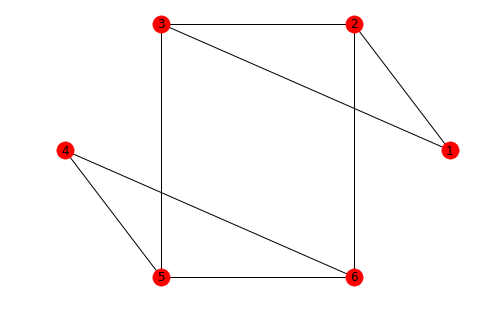

In [4]:
test_net = nx.Graph([(1,2), (1, 3), (2,3), (4,5), (4,6), (5,6), (3,5), (2,6)])
nx.draw_circular(test_net, with_labels=True)

**Question 1** Fill in the table below with the distance and the number of shortest paths between each pair of vertices. (For example, if there are three shortest paths each of length 2, write 2 (3) in the table.)

*[NOTE: You should copy the blank table below into the solution cell and then fill it in]*

| &nbsp;  | node 1 | node 2 | node 3 | node 4 | node 5 | node 6 |
|  ------ | -----  | ------ | ------ | ------ | ------ | ------ |
|  node 1 |   -    |  ? (?) |  ? (?) |  ? (?) |  ? (?) |  ? (?) |
|  node 2 |   -    |  -     |  ? (?) |  ? (?) |  ? (?) |  ? (?) |
|  node 3 |   -    |  -     |   -    |  ? (?) |  ? (?) |  ? (?) |
|  node 4 |   -    |  -     |   -    |   -    |  ? (?) |  ? (?) |
|  node 5 |   -    |  -     |   -    |   -    |   -    |  ? (?) |


<!--
BEGIN QUESTION
name: q1
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

*Write your answer here, replacing this text.*

**Question 2** Calculate the betweenness centrality for node 3 and for node 5 by hand, and fill the answers in below.

<!--
BEGIN QUESTION
name: q2
manual: False
points: 2
-->

In [5]:
bc_node3 = 2
bc_node5 = 2

In [6]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3** Check your calculation using the `nx.betweenness_centrality` function.  
*[NB: be sure to set the normalized argument to False]*.

<!--
BEGIN QUESTION
name: q3
manual: False
points: 1
-->

In [7]:
test_bc = nx.betweenness_centrality(test_net, normalized=False)
test_bc

{1: 0.0, 2: 2.0, 3: 2.0, 4: 0.0, 5: 2.0, 6: 2.0}

In [8]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



In [19]:
# with the function "values", you will get the array of the centrality values
nx.betweenness_centrality(test_net, normalized=False).values()

## Epidemic models and centrality among US Legislators

In this homework, we'll be investigating patterns of connections on Twitter among Members of Congress (MOC). This dataset comes from the official Twitter accounts of members of Congress in the fall of 2016. We've made a few simplifications here:

* On Twitter, following is a *directed relation*. So person A can follow person B without person B necessarily following person A. Here, we've taken these directed relationships and turned them into an undirected network.
* Almost every Senator and Representative is in this dataset, but a few are missing; we'll ignore these missing people here.

The goal of the homework is to continue the analysis we looked at in lecture: we'll try to evaluate how well different metrics for centrality predict outcomes in an SIR epidemic model. The idea is that 'good' measures of centrality should be able to tell us which nodes play an important role in the spread of a disease or idea through a network.

## Exploratory analysis of the dataset

The nodes in the `official_congress_twitter` network have attributes. These attributes include:

* `official_full` - the MOC's full name
* `gender` - the MOC's gender
* `party` - the MOC's political party
* `state` - the MOC's state
* `type` - either `sen` for Senator or `rep` for Representative

Let's start by loading the dataset.

In [9]:
try:
    official_congress_twitter = pickle.load(open('../data/congress-twitter/us_congress_2016_twitter_nx2.pickle', 'rb'))
except:
    official_congress_twitter = pickle.load(open('./us_congress_2016_twitter_nx2.pickle', 'rb'))
    pass

FileNotFoundError: [Errno 2] No such file or directory: './us_congress_2016_twitter_nx2.pickle'

## Exploratory analysis of the dataset

First, we'll explore the dataset, focusing on different ways to understand centrality.

In order to look more closely at the attributes of the members of Congress, we'll make use of this function:

In [17]:
def nodes_to_table(g):
    """
    Given a network `g`, return a Table that has all of the attributes of the
    nodes in the network
    """
    
    df = {}
    df['node_id'] = list(g.nodes())
    
    # assume all nodes have the same attributes
    #att_names = g.node[df['node_id'][0]].keys()
    att_names = g.nodes[df['node_id'][0]].keys()
    
    for att in att_names:
        df[att] = [node[1][att] for node in g.nodes(data=True)]
    
    df = pd.DataFrame(df)
    
    return Table.from_df(df)

The `nodes_to_table` function makes a Table that has the attributes of all of the nodes in the network it is given. We can use it like this:

In [18]:
moc_data1 = nodes_to_table(official_congress_twitter)

moc_data1

There is a lot of information here, but there are three things we're going to add to this table: 

* each node's degree 
* each node's betweenness centrality 
* each node's eigenvector centrality

The only one of these quantities you haven't seen before is the eigenvector centrality. Conceptually, eigenvector centrality is similar to degree and betweenness because it tries to measure how central or important each node in the network is. Roughly speaking, the idea behind eigenvector centrality is that a node is important if it is connected to many important nodes. We won't go into all of the details here, but you can read the [Wikipedia page on eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) if you are curious.

In order to add these three quantities to our Table of node information (`moc_data1`), we will

* compute each quantity for each node
* put the results in a table
* join the table to the `moc_data1` table

**Question 4** Fill in the code below to create a table that has several centrality measures for each node.

<!--
BEGIN QUESTION
name: q4
manual: False
points: 4
-->

In [20]:
moc_node_centrality_dat = Table().with_columns(
)
    'node_id', ... ,
    'betweenness_centrality', ... ,
    'eigenvector_centrality', ... ,
    'degree', ...

moc_node_centrality_dat

In [ ]:
ok.grade("q4");

**Question 5** Now join the centrality measures onto the dataset of node attributes. You can review previous labs and homeworks to see how to join tables.

<!--
BEGIN QUESTION
name: q5
points: 2
manual: False
-->

In [29]:
moc_data = moc_data1.join(..., ...)
print(moc_data.num_rows, moc_data.num_columns)
moc_data
moc_data

In [ ]:
ok.grade("q5");

**Question 6** Use `moc_data` to figure out the average degree of Republicans and Democrats. [Hint: Use select and group functions.]

<!--
BEGIN QUESTION
name: q6
manual: False
points: 3
-->

In [28]:
# Note that you have to change func_name1 and func_name2 as well
party_degree=moc_data.func_name1([..., ...]).func_name2(..., ...)

party_degree

In [ ]:
ok.grade("q6");

**Question 7** Use `moc_data` to figure out the average degree of males and females in the dataset. [Hint: Use select and group functions.]

<!--
BEGIN QUESTION
name: q7
points: 3
manual: False
-->

In [34]:
# Note that you have to change func_name1 and func_name2 as well
gender_degree=moc_data.func_name1([..., ...]).func_name2(..., ...)

gender_degree

In [ ]:
ok.grade("q7");

**Question 8** Make a histogram that shows the degree distribution for moc_data table.

<!--
BEGIN QUESTION
name: q8
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

In [37]:
...

**Question 9** Make a histogram that shows the distribution of betweenness for moc_data table.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

In [39]:
...

**Question 10** Make a histogram that shows the distribution of eigenvector centrality.

<!--
BEGIN QUESTION
name: q10
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

In [40]:
...

**Question 11** Make a scatterplot that compares degree (x axis) and betweenness centrality.

<!--
BEGIN QUESTION
name: q11
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

In [43]:
plt.scatter(..., ...);

**Question 12** Make another scatterplot that compares degree (x axis) and eigenvector centrality.

<!--
BEGIN QUESTION
name: q12
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

In [44]:
plt.scatter(..., ...);

**Question 13** In one or two sentences, how would you describe the relationship between these different centrality measures?

<!--
BEGIN QUESTION
name: q13
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

In [ ]:
...
# please answer the question as a comment here

### Using epidemic models to understand centrality

The plots you made above show that the three different metrics of centrality (degree, eigenvector centrality, and betweenness centrality) do not all agree with each other. Our task now is to investigate which of these three quantities appears to be most effective for capturing how important a node is to the spread of an SIR epidemic on the MOC Twitter network.

One approach to this problem would be to try to analyze the SIR model mathematically: we could see if we could figure out which of the three metrics seems most closely related to the dynamics of the model. The alternative - which we will use here - is to use simulation to study this model. 

We will explore how innoculating nodes based on (1) their degree; and (2) their eigenvector centrality affects the expected size of an SIR epidemic on the MOC Twitter network. The idea is that if, for example, nodes' degrees are a good metric for centrality in an SIR epidemic, then innoculating nodes with high degree should be effective at slowing the spread of an SIR epidemic.

We'll start by bringing in several functions that we used in lab:

In [44]:
def set_status(net, ids, value):
    """
    set the value of the 'status' attribute for the nodes with the given ids
    in the given network
    """
    nx.set_node_attributes(net,  
                           dict([x for x in zip(ids, [value]*len(ids))]),
                          'status')

def get_status(net, ids):
    """
    get the value of the 'status' attributes for the nodes 
    with given ids in the given network
    """
    dat = nx.get_node_attributes(net, 'status')
    return([dat[x] for x in ids])

def count_infected_nodes(net):
    return(np.sum(np.array(list(nx.get_node_attributes(net, 'status').values())) == 'infected'))

def sim_epidemic(net, start_nodes=None, innoculated_nodes=None, beta=0.3, draw=False):
    
    # all nodes start susceptible
    set_status(net, net.nodes(), 'susceptible')

    # innoculated nodes start as recovered
    if innoculated_nodes is not None:
        set_status(net, innoculated_nodes, 'innoculated')
    else:
        innoculated_nodes = []

    eligible_to_start = [x for x in net.nodes() if x not in innoculated_nodes]        
        
    # if no start_nodes specified, pick one node at random as the seed
    if start_nodes is None:
        infected_nodes = np.random.choice(eligible_to_start, 1)
    else:
        infected_nodes = start_nodes

    
    set_status(net, infected_nodes, 'infected')

    incidence = [len(infected_nodes)]
    
    if draw:
        status_cmap = {'susceptible' : '#00FF00', 'infected' : '#FF0000', 'recovered' : '#000000', 'innoculated' : '#0000FF'}
        pos = nx.random_layout(net)
        
        #fig_nums = []

    while count_infected_nodes(net) > 0:

        if draw:
            next_fig, next_ax = plt.subplots() 
            plt.figure(nx.draw(net, 
                               pos=pos,
                               cmap=status_cmap, 
                               node_color=[status_cmap[net.node[node]['status']] for node in net]));
            #nx.draw(net, 
            #                   pos=pos,
            #                   cmap=status_cmap, 
            #                   node_color=[status_cmap[net.node[node]['status']] for node in net],
            #                   ax=next_ax)
            #fig_nums.append(plt.gcf().number)
        
        ## get neighbors of infected nodes
        neighbors = [net.neighbors(x) for x in infected_nodes]

        # see http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
        neighbors = [item for sublist in neighbors for item in sublist]        
        neighbors_status = np.array(get_status(net, neighbors))

        ## set infected nodes to recovered
        set_status(net, infected_nodes, 'recovered')

        ## infect susceptible neighbors with probability beta x number of infected contacts
        ## (a node with more than one infected contact will have more than one draws at being infected here)
        neighbors = [x[0] for x in zip(neighbors, neighbors_status) if x[1] == 'susceptible']
        infect_draws = np.random.random_sample(len(neighbors))
        to_infect = list(np.array(neighbors)[np.where(infect_draws < beta)])

        num_infected_this_round = len(set(to_infect))
        
        set_status(net, to_infect, 'infected')
        infected_nodes = to_infect

        ## record number infected this round (also called incidence at this time step)
        incidence.append(num_infected_this_round)
    
    return incidence

And here are a couple of additional functions that will be helpful when we investigate innoculation strategies below:

In [45]:
## example usage
## get_top_k(moc_data, 'degree', 10)

def get_top_k(data, col, k):
    node_ids = data.sort(col, descending=True).take(np.arange(0,k)).column('node_id')
    return(node_ids)

## example usage
## get_random_k(moc_data, 10)

def get_random_k(data, k):
    node_ids = data.sample(k, with_replacement=False).column('node_id')
    return(node_ids)

### Simulating an SIR epidemic on the MOC Twitter network

To start, we'll get a baseline idea of how an SIR epidemic would unfold in the MOC Twitter network. We'll be working with the following parameter values:

In [46]:
num_vaccines = 300
beta_param = .01
num_sims = 3000

**Question 14** Following the pattern from lecture, simulate `num_sims` SIR epidemics with $\beta=$`beta_param`. Then make a histogram of the distribution of the resulting number infected.  
*[NOTE: this will take about 5 minutes to run]*

<!--
BEGIN QUESTION
name: q14
points: 3
manual: False
-->

In [47]:
%%time
np.random.seed(99)
num_infected = make_array()

# Running this simulation will take about 3min...
for _ in range(...):
    num_infected = np.append(num_infected, np.sum(sim_epidemic(..., beta=...)))
    
moc_sir_res_table = Table().with_column('num_infected', num_infected)
moc_sir_res=moc_sir_res_table.hist()
moc_sir_res

In [ ]:
ok.grade("q14");

**Question 15** Now summarize the SIR epidemic on the MOC Twitter network by calculating the mean number infected in the simulations you just ran.

<!--
BEGIN QUESTION
name: q15
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

In [49]:
moc_sir_mean_infected = np.mean(...)

moc_sir_mean_infected

In [ ]:
ok.grade("q15");

## Exploring innoculation strategies

Now that we have some understanding of how an SIR epidemic would unfold on the MOC Twitter network, we're going to try to compare different strategies for innoculating nodes in the network.
The idea is to use this approach to try and understand what characteristics make for **central** nodes in this network. We'll consider a node to be central if innoculating it reduces the expected size of the epidemic by a lot.

We're going to compare three different ways of measuring centrality: degree centrality, betweenness centrality, and eigenvector centrality. Our goal is to determine which of these three different centrality measures does the best job of telling us which nodes to innoculate in order to prevent the spread of an epidemic on this MOC Twitter network.

Note that we're using the language of disease in this assignment, as we have in lecture. But the SIR model could describe the spread of anything that is governed by simple contagion. For example, in the case of the MOC Twitter network, it might be more interesting to think about information spreading through a simple contagion-type mechanism. In that case, this analysis helps us uncover the centrality metric that best predicts which Members of Congress are most important for the flow of information across the MOC Twitter network.

### Innoculate by degree

First, we'll investigate degree centrality--that is, we'll see how much the spread of an SIR epidemic is reduced when we target nodes with high degree for vaccination.

In order to do this, let's identify the Members of Congress with the highest degree:

In [51]:
top_degree_id = get_top_k(moc_data, 'degree', num_vaccines)
top_degree_id

**Question 16** Now, let's re-run our epidemic simulation, this time innoculating the nodes that have the highest degrees (which we just identified above).

<!--
BEGIN QUESTION
name: q16
points: 1
manual: False
-->

In [53]:
%%time
np.random.seed(99)
num_infected_innocdegree = make_array()

for _ in range(...):
    num_infected_innocdegree = np.append(num_infected_innocdegree, 
                                         np.sum(sim_epidemic(..., 
                                                             beta=...,
                                                             innoculated_nodes=...)))

num_infected_table=Table().with_column('num_infected', num_infected_innocdegree)
num_infected_table

In [ ]:
ok.grade("q16");

You can check the distribution of the numbers infected over the simulations using a histogram:

In [55]:
num_infected_table.hist()

**Question 17** Now calculate the mean number infected in the simulations you just ran.

<!--
BEGIN QUESTION
name: q17
points: 3
manual: False
-->

In [59]:
moc_target_degree_mean_infected = ...
moc_target_degree_mean_infected

moc_target_degree_mean_infected

In [ ]:
ok.grade("q17");

### Innoculate by eigenvector centrality

Next, we'll investigate eigenvector centrality--that is, we'll see how much the spread of an SIR epidemic is reduced when we target nodes with high eigenvector centrality for vaccination.

In order to do this, let's identify the Members of Congress with the highest eigenvector centrality:

In [61]:
top_ec_id = get_top_k(moc_data, 'eigenvector_centrality', num_vaccines)
top_ec_id

**Question 18** Now, let's re-run our epidemic simulation, this time innoculating the nodes that have the highest eigenvector centralities (which we just identified above).

<!--
BEGIN QUESTION
name: q18
points: 1
manual: False
-->

In [62]:
%%time
np.random.seed(99)
num_infected_innocec = make_array()

for _ in range(...):
    num_infected_innocec = np.append(num_infected_innocec, 
                                         np.sum(sim_epidemic(..., 
                                                             beta=...,
                                                             innoculated_nodes=...)))
    
num_infected_table2=Table().with_column('num_infected', num_infected_innocec)
num_infected_table2

In [ ]:
ok.grade("q18");

You can check the distribution of the numbers infected over the simulations using a histogram:

In [64]:
num_infected_table2.hist()

**Question 19** Now calculate the mean number infected in the simulations you just ran.

<!--
BEGIN QUESTION
name: q19
points: 3
manual: False
-->

In [64]:
moc_target_ec_mean_infected = np.mean(num_infected_innocec)
moc_target_ec_mean_infected

In [ ]:
ok.grade("q19");

### Innoculate by betweenness centrality

Next, we'll investigate betweenness centrality--that is, we'll see how much the spread of an SIR epidemic is reduced when we target nodes with high betweenness centrality for vaccination.

In order to do this, let's identify the Members of Congress with the highest betweenness centrality:

In [67]:
top_bc_id = get_top_k(moc_data, 'betweenness_centrality', num_vaccines)
top_bc_id

**Question 20** Now, let's re-run our epidemic simulation, this time innoculating the nodes that have the highest betweenness centralities (which we just identified above).

<!--
BEGIN QUESTION
name: q20
points: 1
manual: False
-->

In [68]:
%%time
np.random.seed(99)
num_infected_innocbc = make_array()

for _ in range(num_sims):
    num_infected_innocbc = np.append(num_infected_innocbc, 
                                         np.sum(sim_epidemic(..., 
                                                             beta=...,
                                                             innoculated_nodes=...)))
    
num_infected_table3=Table().with_column('num_infected', num_infected_innocbc)    
num_infected_table3

In [ ]:
ok.grade("q20");

You can check the distribution of the simulated numbers of people infected using a histogram:

In [70]:
num_infected_table3.hist()

**Question 21** Now calculate the mean number infected in the simulations you just ran.

<!--
BEGIN QUESTION
name: q21
points: 3
manual: False
-->

In [72]:
moc_target_bc_mean_infected = ...
moc_target_bc_mean_infected

moc_target_bc_mean_infected

In [ ]:
ok.grade("q21");

### Innocluate at random

Finally, we'll compare the previous approaches to just vaccinating people at random.

In order to do this, we'll take a random sample of nodes in the MOC Twitter network and innoculate them.

In [74]:
random_id = get_random_k(moc_data, num_vaccines)
random_id

**Question 22** Now, let's re-run our epidemic simulation, this time innoculating the nodes that we just randomly picked.

<!--
BEGIN QUESTION
name: q22
points: 1
manual: False
-->

In [75]:
%%time
np.random.seed(99)
num_infected_innocrandom = make_array()

for _ in range(num_sims):
    num_infected_innocrandom = np.append(num_infected_innocrandom, 
                                         np.sum(sim_epidemic(..., 
                                                             beta=...,
                                                             innoculated_nodes=...)))
    
num_infected_table4=Table().with_column('num_infected', num_infected_innocrandom)    
num_infected_table4

In [ ]:
ok.grade("q22");

You can check the distribution of the simulated numbers of people infected using a histogram:

In [77]:
num_infected_table4.hist()

**Question 23** Now calculate the mean number infected in the simulations you just ran.

<!--
BEGIN QUESTION
name: q23
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

In [78]:
moc_target_random_mean_infected = ...
moc_target_random_mean_infected


moc_target_random_mean_infected

In [ ]:
ok.grade("q23");

## Compare the different strategies

Finally, let's compare the four innoculation strategies that we just simulated.

In [81]:
innoc_results = Table().with_columns('random', num_infected_innocrandom,
                                     'eigenvector', num_infected_innocec,
                                     'betweenness', num_infected_innocbc,
                                     'degree', num_infected_innocdegree)

innoc_results

In [82]:
innoc_results.hist(['random', 'eigenvector', 'degree', 'betweenness'], overlay=False)

In [83]:
diff_ec_rand = innoc_results.column('eigenvector') - innoc_results.column('random')

Table().with_column('Eigenvector - Random', diff_ec_rand).hist()
print("Average difference in # infected under eigenvector - random targeting strategy: ", np.mean(diff_ec_rand))

In [84]:
diff_deg_rand = innoc_results.column('degree') - innoc_results.column('random')

Table().with_column('Degree - Random', diff_deg_rand).hist()
print("Average difference in # infected under Degree - random targeting strategy: ", np.mean(diff_deg_rand))

In [85]:
diff_bc_rand = innoc_results.column('betweenness') - innoc_results.column('random')

Table().with_column('Betweenness - Random', diff_bc_rand).hist()
print("Average difference in # infected under betweenness - random targeting strategy: ", np.mean(diff_bc_rand))

**Question 24** Based on these results, which innoculation strategy appears to be most effective?

<!--
BEGIN QUESTION
name: q24
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

In [ ]:
...
# please answer the question as a comment here

### Examing the strategies with different budgets

Now we're going to conduct one final analysis to understand this problem. Above, we assumed that we always had a fixed number of vaccines. Next, we'll repeat the analysis we did above many different times, each time changing the number of vaccines that we have to distribute. This will help us understand whether or not our conclusions depend on the budget.

**Question 25** The loop below repeats the analysis above many times across different parameter values. Fill in the missing pieces.   
[NOTE: This will take 1-2 minutes to run]

<!--
BEGIN QUESTION
name: q25
points: 5
manual: False
-->

In [86]:
%%time
np.random.seed(99)
reps_per_param = 10

num_vaccines = np.repeat(np.array([50, 100, 150, 200, 250, 300, 350, 400]),
                         reps_per_param)

num_infected_random = make_array()
num_infected_degree = make_array()
num_infected_bc = make_array()
num_infected_ec = make_array()

for cur_num_vaccines in np.repeat(num_vaccines, reps_per_param):

        random_ids = get_random_k(moc_data, cur_num_vaccines)
        top_ec_ids = get_top_k(moc_data, ..., cur_num_vaccines)
        top_bc_ids = get_top_k(moc_data, ..., cur_num_vaccines)
        top_degree_ids = get_top_k(moc_data, ..., cur_num_vaccines)

        num_infected_random = np.append(num_infected_random, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=...)))
        
        num_infected_ec = np.append(num_infected_ec, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=...)))
        num_infected_bc = np.append(num_infected_bc, 
                                    np.sum(sim_epidemic(official_congress_twitter, 
                                                        beta=beta_param,
                                                        innoculated_nodes=...)))
        num_infected_degree = np.append(num_infected_degree, 
                                        np.sum(sim_epidemic(official_congress_twitter, 
                                                            beta=beta_param,
                                                            innoculated_nodes=...)))

sim_results = Table().with_column('num_vaccines', np.repeat(num_vaccines, reps_per_param),
                                  'num_infected_random', num_infected_random,
                                  'num_infected_degree', num_infected_degree,
                                  'num_infected_bc', num_infected_bc,
                                  'num_infected_ec', num_infected_ec)
sim_results

In [ ]:
ok.grade("q25");

Next, let's plot the results of the simulation:

In [90]:
sim_results.scatter('num_vaccines', overlay=True, alpha=.3)

It's a little hard to tell what's going on because there's a lot of information being plotted. So we'll aggregate the results of the simulation by calculating the average outbreak size for each vaccination strategy and vaccine budget. Then we'll plot these averages.

**Question 26** Calculate the average number infected for each value of `num_vaccines` and for each innoculation strategy.

<!--
BEGIN QUESTION
name: q26
points: 2
manual: False
-->

In [91]:
sim_results_aggregate = sim_results.group(..., ...)

sim_results_aggregate

In [ ]:
ok.grade("q26");

In [93]:
print('avg infected when innoculation based on:')
print('... degree: ', sim_results_aggregate.column('num_infected_degree mean').mean())
print('... betweenness centrality: ', sim_results_aggregate.column('num_infected_bc mean').mean())
print('... eigenvector centrality: ', sim_results_aggregate.column('num_infected_ec mean').mean())
print('... random:', sim_results_aggregate.column('num_infected_random mean').mean())

Finally, let's plot the aggregate results; we'll see a clearer pattern here:

In [94]:
sim_results_aggregate.scatter('num_vaccines', overlay=True)

**Question 27** Based on these results, which innoculation strategy appears to be most effective across the range of vaccine budgets we investigated? Does this change your conclusion from before?

<!--
BEGIN QUESTION
name: q27
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

In [ ]:
...
# please answer the question as a comment here

# SUBMIT YOUR ASSIGNMENT

In [ ]:
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Please don't forget to submit the generated pdf file on Gradescope after running the submission code.

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw6.ipynb', 'hw6.pdf')
ok.submit()